# A First look at the Data

## Introduction

In this section, the paths to the data will be set so that the data can be loaded. This will allow us to explain the data structure and perform a few sanity checks. Finally, some examples of simple plots of the raw data will be provided

#### Import the Required Modules

In [4]:
import mne
import os
import numpy as np
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
)

## File Overview

The chapter relies on the input file (embedded in the BIDS structure)

```
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
```

## Loading the BIDS Data

The first step is to prepare the data for reading. The OPM data, which was restructured into the BIDS format in the previous chapter, will be used in this section for subsequent analysis.This requires creating the mne_bids.BIDSPath which point to the path of MNE BIDS folder.

#### Specify your BIDS parameters along with the BIDS folder path

In [5]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'

data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
                     task=task, run=run, suffix=meg_suffix, 
                     extension=meg_extension, root=bids_root)

#### We now created the BIDSPath object, let's read the OPM data

In [6]:
print(bids_path)
raw = read_raw_bids(bids_path=bids_path, 
                    verbose=False,
                    extra_params={'preload':True})

C:/Users/rakshita/Documents/Cerca_raw_files/Cerca_Spatt_BIDS/sub-01/ses-01/sub-01_ses-01_task-SpAtt_run-01_meg.fif


## Inspecting at the Data

To get some basic information from the `.fif` file write:

In [7]:
print(raw)

<Raw | sub-01_ses-01_task-SpAtt_run-01_meg.fif, 219 x 1539808 (2053.1 s), ~2.52 GiB, data loaded>


The dataset has a size of 2.52 GB and spans a total recording duration of 2053.1 seconds. After downsampling to 750 Hz, this yields 1,539,808 time points across the entire recording. The data were collected from 219 channels, comprising 192 magnetometer sensors and 27 stimulus-related channels.

In [8]:
print(raw.info)

<Info | 16 non-empty values
 bads: []
 ch_names: Trigger 1, Trigger 2, Trigger 3, Trigger 4, Trigger 5, Trigger ...
 chs: 27 Stimulus, 192 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 device_info: 2 items (dict)
 dig: 15603 items (3 Cardinal, 15600 Extra)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 219
 projs: []
 sfreq: 750.0 Hz
 subject_info: <subject_info | his_id: sub-01, sex: 0, hand: 0>
>


This information shows important parameters of the dataset. For instance the sampling frequency is 750 Hz (sfreq). The data were lowpass filtered at 250.0 Hz (lowpass) prior to the digital sampling. The experimenter is anonymized and the recording data is not meaningful as to comply with GDPR rules.

**Question 1:** What role does the 250 Hz analog low‑pass filter play in the data acquisition process? (See Analog Filters for Data Conversion, Chapter 3; Smith et al., 1999)

## Bad Channels

We’ll first flag channels as “bad” in the raw dataset based on what we observed during acquisition. After that, in later chapters we’ll further augment the bad‐channel list by identifying additional outliers using the power spectral density estimates.


In [8]:
ch_names = raw.info['ch_names']
bad_chs = ['B4', 'H6']
bad_channels = [name for name in ch_names if any(ch in name for ch in bad_chs)]
raw.info['bads'] = bad_channels
raw.save
# Print the bad channels 
print("Bad channels marked:", raw.info['bads'])

Bad channels marked: ['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X']


## Estimating the PSDs
The data object (raw) allows for a simple inspection of the data by calculating the spectra: As a first step calcualte the PSDs of all the sensors for 0.1-120 HZ frequency range using the MNE functions. Also note that the sampling frequency 750 Hz and therefore chose $N_{FFT}$ = 1500 to achive a 0.5 Hz spectral resolution.

In [10]:
n_fft = 1500# Get the channel names from raw.info
raw_PSD = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2))

Effective window size : 2.000 (s)


A standard Welch method is applied here. The data are divided into sections being 2 s long (3000 samples) with a 1 s overlap (1000 samples). This results in a 0.5 Hz resolution prior to calculating the FFT of each section a Hamming taper is multiplied.

#### Plot the PSD computed above

Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


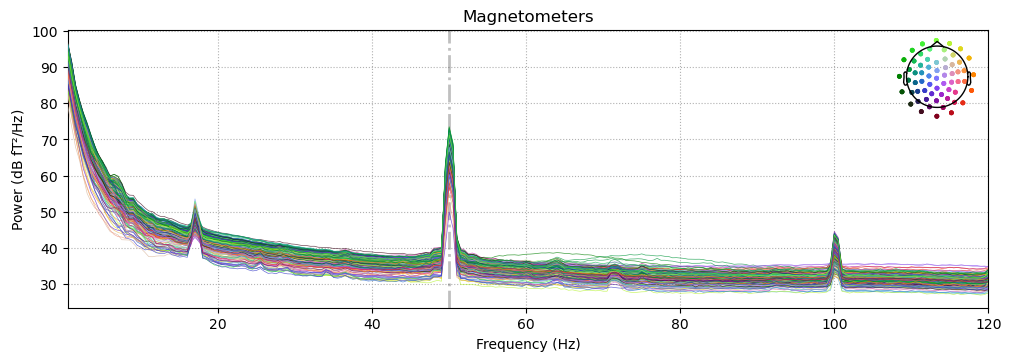

In [11]:
%matplotlib inline  
raw_PSD.plot(exclude='bads',picks='mag');



Note the 50 Hz line noise. The frequency of the line noise is 50 Hz in European countries including Russia and Asian countries like India, China whereas it is 60 in South Korea as well as South and North America. In Japan it can be either 50 or 60 Hz depending on the region.





## To show the raw data using the interactive functions of the plotting tool

In [12]:
%matplotlib qt
raw.plot(duration=10, title='Raw')

Using qt as 2D backend.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x28a2eaf2100) at 0x00000289B2098880>

Waiting for Loading-Thread to finish... (max. 10 sec)


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Channels marked as bad:
['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X']




This will open the plot in a new window. Use the arrow keys to move over channels and time. Click on the help button for more information.

**Question 4:** Scroll through the OPM data and identify the following artifacts (include figures in the response):

- Eye‑blink  
- A muscle contraction (characterized by high‑frequency activity)  
- The cardiac artifact  



## Preregistration and Publication

Will update very soon

## References

Smith, W.S. (1997) *The Scientist and Engineer's Guide to Digital Signal Processing*. California Technical Publishing. ISBN 0-9660176-3-3. Online version: [The Scientist and Engineer's Guide to DSP](https://www.dspguide.com/)
